# How to Use Harmony-Py to Request and Create an Area-Averaged Time Series and Time-Averaged Map

### Overview

This notebook uses the `harmony-py` library to make a Cloud Giovanni area-averaged time series and time-averaged map using `pandas` and `rioxarray`.

This notebook was written using Python 3.10, and requires these libraries and files:

- Earthdata Login Account: https://urs.earthdata.nasa.gov/users/new
- [Harmony](https://harmony-py.readthedocs.io/en/main/)
- [xarray](https://docs.xarray.dev/en/stable/) (must be >=2025.4.0)
- [rioxarray](https://corteva.github.io/rioxarray/stable/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/quick-start/)
- [Pandas](https://pandas.pydata.org/docs/)
- [Matplotlib](https://matplotlib.org/)
- [Cartopy](https://cartopy.readthedocs.io/v0.25.0.post2/)
- [Metpy](https://unidata.github.io/MetPy/latest/index.html)


In [43]:
from harmony import Dimension, Client, Collection, Request, Environment
import earthaccess
import requests
import datetime as dt
import os
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from metpy.plots import ctables
import requests
import pandas as pd
from urllib.parse import urlparse, unquote
from IPython.display import display, HTML

def display_giovanni_metadata(filter_shortnames, scroll_height=500):
    """
    Fetches metadata from Giovanni API and displays a scrollable table in Jupyter Notebook
    with selected columns plus parsed OPeNDAP variable names, including Concept ID from Earthdata.
    
    Parameters:
        filter_shortnames (list of str): Only display rows where ShortName is in this list. (Required)
        scroll_height (int): Maximum height of the scrollable table in pixels.
    """
    
    if not filter_shortnames:
        raise ValueError("You must provide at least one Short Name in filter_shortnames.")
    
    # Fetch JSON from Giovanni API
    url = "https://api.giovanni.earthdata.nasa.gov/get_metadata_json"
    response = requests.get(url)
    data = response.json()
    docs = data["response"]["docs"]

    # Helper to extract variable names from OPeNDAP URL
    def extract_variables(opendap_url):
        if not opendap_url:
            return ""
        query = urlparse(opendap_url).query
        query = unquote(query)
        vars_ = [v.split('[')[0] for v in query.split(',')]
        return ", ".join(vars_)

    # Helper to get Concept ID from Earthdata using Collection.ShortName
    def get_concept_id(short_name):
        results = earthaccess.search_datasets(short_name=short_name)
        concept_id = results[0].concept_id() if results else ""
        return concept_id

    # Filter docs by ShortName first
    docs_filtered = [doc for doc in docs if doc.get("Collection.ShortName") in filter_shortnames]

    # Build rows
    rows = []
    for doc in docs_filtered:
        var_id = doc.get("Variable.Id", "")
        short_name = doc.get("Collection.ShortName", "")
        concept_id = get_concept_id(short_name)
        var_units = doc.get("Variable.Units", "")
        doi = doc.get("Collection.DOI", "")
        opendap_vars = extract_variables(doc.get("Collection.OpendapUrl", ""))
        rows.append([var_id, concept_id, var_units, short_name, doi, opendap_vars])

    # Create DataFrame
    headers = ["Giovanni Variable ID", "Concept ID", "Units", "ShortName", "DOI", "Dimensions"]
    df = pd.DataFrame(rows, columns=headers)

    # Sort by ShortName
    df = df.sort_values(by="ShortName").reset_index(drop=True)

    # Scrollable HTML table
    html_table = df.to_html(notebook=True, index=False)
    scrollable_html = f"<div style='max-height:{scroll_height}px; overflow:auto'>{html_table}</div>"
    display(HTML(scrollable_html))





## 1. Area-Averaged Timeseries Request
Let's make a request with `harmony-py` for an area averaged timeseries on the GPM_3IMERGHH_07 collection.

This request will query the `precipitation` variable from the GPM_3IMERGHH_07 collection, enabled as part of the Cloud Giovanni service. A table of other enabled variables can be viewed in the [Giovanni in the Cloud: Time Series Service](https://disc.gsfc.nasa.gov/information/documents?title=Giovanni%20In%20The%20Cloud:%20Time%20Series%20Service#supported-collections) document. Additionally, the Concept ID of the desired collection will need to be retrieved by querying the Common Metadata Repository via `earthaccess`, and the strings of the latitude and longitude dimensions will need to be specified (i.e., "lat"/"lon", or "latitude"/"longitude").

This will download the time series data as a CSV file to the directory that the notebook is run from.

### 1a. Specify Spatiotemporal Parameters and Retrieve Collection Metadata

The table below displays the available variables and their units, short name, DOI, and dimensions. 

In this notebook, we will use the GPM_3IMERGHH collection, which we can pass into `filter_shortnames` to view all enabled variables for that particular collection. This shortname can be found on the [Dataset Landing Page](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_07/summary?keywords=GPM_3IMERGHH_07) for the collection desired.

Take note of the Giovanni Variable ID, the Concept ID, and the dimension values-specifically the names of the latitude and longitude dimensions. We will use these strings in our Harmony-py query.

In [46]:
display_giovanni_metadata(filter_shortnames=["GPM_3IMERGHH"])

Giovanni Variable ID,Concept ID,Units,ShortName,DOI,Dimensions
GPM_3IMERGHH_07_precipitationQualityIndex,C2723754847-GES_DISC,index,GPM_3IMERGHH,10.5067/GPM/IMERG/3B-HH/07,"precipitationQualityIndex, lat, lon, time, time..."
GPM_3IMERGHH_07_precipitation,C2723754847-GES_DISC,mm/hr,GPM_3IMERGHH,10.5067/GPM/IMERG/3B-HH/07,"precipitation, lat, lon, time, time_bnds"
GPM_3IMERGHH_07_randomError,C2723754847-GES_DISC,mm/hr,GPM_3IMERGHH,10.5067/GPM/IMERG/3B-HH/07,"randomError, lat, lon, time, time_bnds"
GPM_3IMERGHH_07_probabilityLiquidPrecipitation,C2723754847-GES_DISC,percent,GPM_3IMERGHH,10.5067/GPM/IMERG/3B-HH/07,"probabilityLiquidPrecipitation, lat, lon, time,..."


Next, we will specify our start and end time, the latitude/longitude point for our time series, and the concept ID. Then, we will open a Harmony client by passing our Earthdata Login username and password.

To use credentials stored in a .netrc file, simply replace `Client(auth=('your_edl_username', 'your_edl_password'))` with `harmony_client = Client()`

In [ ]:
variable = "GPM_3IMERGHH_07_precipitation"
concept_id = "C2723754847-GES_DISC"

start = dt.datetime(2021, 8, 29, 7, 30)
stop = dt.datetime(2021, 8, 29, 17, 30) 

lat = Dimension("lat", 25, 35)
lon = Dimension("lon", -110, -78)

harmony_client = Client(auth=('your_edl_username', 'your_edl_password'))

In [ ]:
collection = Collection(id=concept_id)
request = Request(
    collection=collection,
    temporal={"start": start, "stop": stop},
    dimensions=[lat, lon],
    variables=[variable],
    format="text/csv",
    average="area",
)

job_id = harmony_client.submit(request)
results = harmony_client.download_all(job_id)
for r in results:
    precip_timeseries_fn = r.result()
    assert os.path.exists(precip_timeseries_fn)

7858121_GIOVANNI-areaAvgTimeSeries.GPM_3IMERGHH_07_precipitation.20210829-20210829.110W_25N_78W_35N.csv


### Opening a CSV with pandas.
You can open a CSV with `pandas.read_csv()`. We will strip the metadata attributes for convenience.

In [3]:
precip_timeseries_attrs = {}
with open(precip_timeseries_fn) as f:
    # Parse the header attributes until the line with just a comma
    done = False
    line = f.readline().strip()
    precip_timeseries_attrs = {}
    while line != ",":
        attr, value = line.split(",", 1)
        precip_timeseries_attrs[attr] = value
        line = f.readline().strip()
    # Parse the data
    precip_timeseries_df = pd.read_csv(f, parse_dates=[0])

In [4]:
precip_timeseries_df

,time,mean_GPM_3IMERGHH_07_precipitation
0,2021-08-29 07:30:00,0.461005
1,2021-08-29 08:00:00,0.435542
2,2021-08-29 08:30:00,0.394190
3,2021-08-29 09:00:00,0.428853
4,2021-08-29 09:30:00,0.456969
5,2021-08-29 10:00:00,0.470735
6,2021-08-29 10:30:00,0.498274
7,2021-08-29 11:00:00,0.520958
8,2021-08-29 11:30:00,0.520602
9,2021-08-29 12:00:00,0.485872


## Plotting an area-averaged time series
We can plot a `pandas` dataframe with `.plot()`

<Axes: xlabel='time', ylabel='Area-averaged time series [mm/hr]'>

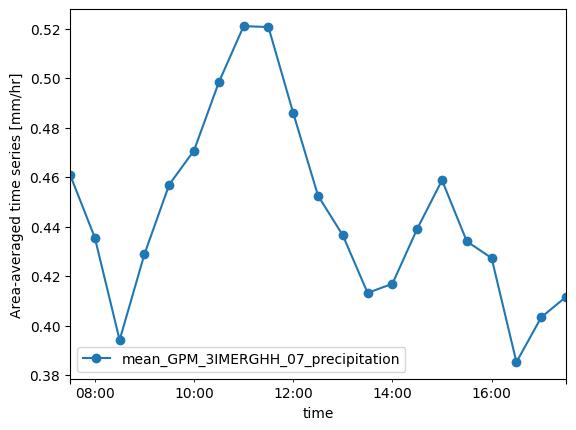

In [5]:
precip_timeseries_df.plot.line("time","mean_GPM_3IMERGHH_07_precipitation", ylabel='Area-averaged time series [mm/hr]', marker='o')

## Time Averaged Map Request
Let's make a request with `harmony-py` for a time averaged map. The time averaged map returns a geotiff.

In [ ]:
harmony_client = Client()
collection = Collection(id=)
request = Request(
    collection=collection,
    temporal={"start": dt.datetime(2021, 8, 29, 7, 30), "stop": dt.datetime(2021, 8, 29, 17, 30)},
    dimensions=[Dimension("lat", 25, 35), Dimension("lon", -110, -78)],
    variables=["GPM_3IMERGHH_07_precipitation"],
    format="image/tiff",
    average="time",
)

job_id = harmony_client.submit(request)
results = harmony_client.download_all(job_id)
for r in results:
    time_avg_map_fn = r.result()
    assert os.path.exists(time_avg_map_fn)

7858122_GIOVANNI-timeAvgMap.GPM_3IMERGHH_07_precipitation.20210829-20210829.110W_25N_78W_35N.tif


### Reading the time averaged map with `rioxarray`
The time averaged map returns a geotiff so we will open this data with [`rioxarray`](corteva.github.io/rioxarray/stable/readme.html) a `rasterio` xarray extension.

In [43]:
precipitation_tif_xds =  rioxarray.open_rasterio(time_avg_map_fn, mask_and_scale=True) # Note we mask NoData values (FillValues)
precipitation_tif_xds

<xarray.DataArray (band: 1, y: 100, x: 320)> Size: 128kB
[32000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB -109.9 -109.8 -109.7 ... -78.25 -78.15 -78.05
  * y            (y) float64 800B 25.05 25.15 25.25 25.35 ... 34.75 34.85 34.95
    spatial_ref  int64 8B 0
Attributes:
    cell_methods:          time: mean
    Conventions:           CF-1.10
    DOI:                   10.5067/GPM/IMERG/3B-HH/07
    latitude_resolution:   0.1
    longitude_resolution:  0.1
    long_name:             Multi-satellite precipitation estimate with gauge ...
    product_short_name:    GPM_3IMERGHH
    product_version:       7
    units:                 mm/hr
    userenddate:           2021-08-29T17:30:00.000Z
    userstartdate:         2021-08-29T07:30:00.000Z
    AREA_OR_POINT:         Area

You can also read a geotiff directly with `xarray` with the `rasterio` engine. Here is more [information](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html#rioxarray) on how to read geotiffs and why you would decide to use `rioxarray.open_rasterio()`

In [44]:
# Open as a xr.Dataset object with a data variable 'band_data'
xr.open_dataset(time_avg_map_fn, engine='rasterio')

<xarray.Dataset> Size: 131kB
Dimensions:      (band: 1, x: 320, y: 100)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB -109.9 -109.8 -109.7 ... -78.25 -78.15 -78.05
  * y            (y) float64 800B 25.05 25.15 25.25 25.35 ... 34.75 34.85 34.95
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 128kB ...

In [45]:
# Open as a xr.DataArray object named 'band_data'
xr.open_dataarray(time_avg_map_fn, engine='rasterio')

# Note opening as a DataArray or Dataset object will perform a mask_and_scale by default

<xarray.DataArray 'band_data' (band: 1, y: 100, x: 320)> Size: 128kB
[32000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB -109.9 -109.8 -109.7 ... -78.25 -78.15 -78.05
  * y            (y) float64 800B 25.05 25.15 25.25 25.35 ... 34.75 34.85 34.95
    spatial_ref  int64 8B ...
Attributes:
    cell_methods:          time: mean
    Conventions:           CF-1.10
    DOI:                   10.5067/GPM/IMERG/3B-HH/07
    latitude_resolution:   0.1
    longitude_resolution:  0.1
    long_name:             Multi-satellite precipitation estimate with gauge ...
    product_short_name:    GPM_3IMERGHH
    product_version:       7
    units:                 mm/hr
    userenddate:           2021-08-29T17:30:00.000Z
    userstartdate:         2021-08-29T07:30:00.000Z
    AREA_OR_POINT:         Area

### Plotting a time averaged map
We can use xarray's plotting functionality with `rioxarray`. Xarray's plotting functionality is a wrapper around `matplotlib`.

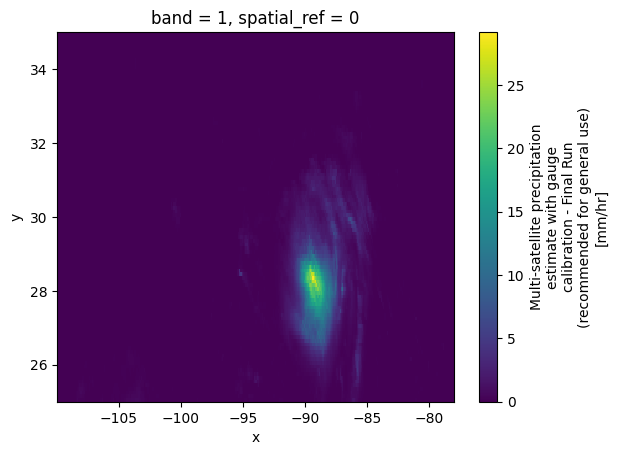

In [40]:
precipitation_tif_xds.plot()

We can also make plots directly with `matplotlib` and a custom precipitation color map from [metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html)

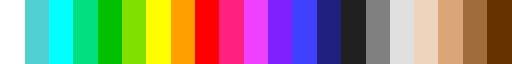

In [41]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap

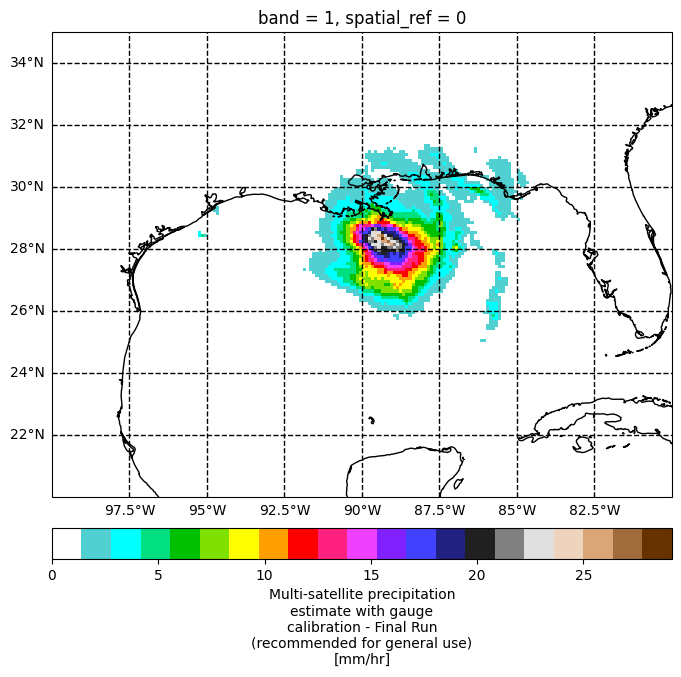

In [42]:
# Set the figure size, projection, extent and grid lines to the plot
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100, -80, 20, 35])
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', linestyle='--')
gl.right_labels = False
gl.top_labels = False

# Get the minimum and maximum values in the array
vmin = precipitation_tif_xds.min()
vmax = precipitation_tif_xds.max()

# Plot the time averaged map
precipitation_tif_xds.plot(cmap=cmap, cbar_kwargs={"orientation": "horizontal", "pad": 0.05}, vmin=vmin, vmax=vmax)